In [1]:
%load_ext autoreload
%autoreload 2

# 3rd party imports
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import SimpleITK as sitk
from tqdm import tqdm
import nibabel as nib


# Local imports
import modules.laplacian as laplacian
import modules.jacobian as jacobian

In [9]:
def get_neighborhood(point, points, max_dist):
    # Get the Euclidean distance between the point and all other points
    distances = np.linalg.norm(points - point, axis=1)
    
    # Get the indices of the points within the neighborhood
    neighborhood_indices = np.where(distances <= max_dist)[0]
    
    # Get the points within the neighborhood
    neighborhood = points[neighborhood_indices]
    
    #neighborhood = [pt for pt in neighborhood if pt != point]
    
    return neighborhood_indices, neighborhood


import numpy as np

def angle_between_vectors(v1, v2):
    # arccos (A dot B / |A||B|)
    # Compute the dot product
    dot_product = np.dot(v1, v2)
    
    # Compute the magnitudes of the vectors
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    
    if magnitude_v1 == 0 or magnitude_v2 == 0:
        return 0, 0
    
    # Compute the cosine of the angle
    cos_theta = dot_product / (magnitude_v1 * magnitude_v2)
    
    # Clip the cosine value to the range [-1, 1] to avoid numerical issues
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    
    # Compute the angle in radians
    angle_rad = np.arccos(cos_theta)
    
    # Convert the angle to degrees
    angle_deg = np.degrees(angle_rad)
    
    return angle_rad, angle_deg

m1 = np.array([0, 1, 0])
f1 = np.array([0, 1, 4])

m2 = np.array([0, 3, 0])
f2 = np.array([0, 4, 4])

# Example vectors
# v1 = np.array([1, 0, 0])
# v2 = np.array([1, 0.5, 0])

v1 = f1 - m1
v2 = f2 - m2

# Compute the angle between the vectors
angle_rad, angle_deg = angle_between_vectors(v1, v2)

# Check if the angle exceeds a certain threshold (e.g., 45 degrees)
threshold_deg = 45
if angle_deg > threshold_deg:
    print(f"The vectors differ by a lot: {angle_deg:.2f} degrees")
else:
    print(f"The vectors do not differ by a lot: {angle_deg:.2f} degrees")

The vectors do not differ by a lot: 14.04 degrees


Load deformation field

In [10]:
# Input parameters
CURR_IDX = 350
base_path = "data/base_unique_correspondences/registered_output/deformation3d.npy"
mpoints_path = "data/base_unique_correspondences/mpoints.npy"
fpoints_path = "data/base_unique_correspondences/fpoints.npy"

# Load the numpy array and compute the jacobian determinant
mpoints = np.load(mpoints_path)
fpoints = np.load(fpoints_path)

# Change the 0th index in each element to 0
mpoints[:, 0] = 0
fpoints[:, 0] = 0

cvectors = fpoints - mpoints  # Correspondence vectors

print("Correspondence point shape:", fpoints.shape)
print("First five fixed points:\n", fpoints[:5])
print("First five moving points:\n", mpoints[:5])
print("First five correspondence vectors:\n", cvectors[:5])

Correspondence point shape: (1319, 3)
First five fixed points:
 [[  0.  10. 175.]
 [  0.  10. 175.]
 [  0.  10. 174.]
 [  0.  10. 176.]
 [  0.  10. 181.]]
First five moving points:
 [[  0.  17. 178.]
 [  0.  17. 179.]
 [  0.  18. 172.]
 [  0.  18. 180.]
 [  0.  15. 187.]]
First five correspondence vectors:
 [[ 0. -7. -3.]
 [ 0. -7. -4.]
 [ 0. -8.  2.]
 [ 0. -8. -4.]
 [ 0. -5. -6.]]


In [19]:
MAX_DIST = 30
MAX_DEG = 60

mpoints_corrected = mpoints.copy()
fpoints_corrected = fpoints.copy()
cvectors_corrected = cvectors.copy()

# Process point orientations
outlier_found = True
num_runs = 0
total_outliers = 0
while outlier_found:
    outlier_found = False
    outlier_indices = []
    num_outliers = 0
    for i in range(len(fpoints_corrected)):
        curr_point = fpoints_corrected[i]
        curr_vector = cvectors_corrected[i]
        #print("Current point:", curr_point)
        neighborhood_idx, neighborhood = get_neighborhood(curr_point, fpoints_corrected, MAX_DIST)

        # Compute the average correspondence vector in the neighborhood
        average_vector = np.mean(cvectors_corrected[neighborhood_idx], axis=0)
        angle_rad, angle_deg = angle_between_vectors(average_vector, curr_vector)
        if angle_deg > MAX_DEG:
            num_outliers += 1
            outlier_indices.append(i)
            outlier_found = True
            #print(f"Point {i} has a large angle of {angle_deg:.2f} degrees")
            #print(angle_deg)

    # Remove outlier indices from moving and fixed points
    mpoints_corrected = np.delete(mpoints_corrected, outlier_indices, axis=0)
    fpoints_corrected = np.delete(fpoints_corrected, outlier_indices, axis=0)
    cvectors_corrected = np.delete(cvectors_corrected, outlier_indices, axis=0)
    
    print("Number of outliers:", num_outliers, f"out of {len(fpoints_corrected)} points")
    total_outliers += num_outliers
    num_runs += 1

print("\nNumber of runs:", num_runs)
print("Number of points removed:", total_outliers)
print("Number of points in the corrected points:", len(fpoints_corrected), "/", len(fpoints))

Number of outliers: 222 out of 1097 points
Number of outliers: 21 out of 1076 points
Number of outliers: 2 out of 1074 points
Number of outliers: 1 out of 1073 points
Number of outliers: 0 out of 1073 points

Number of runs: 5
Number of points removed: 246
Number of points in the corrected points: 1073 / 1319


fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.05069231986999512s
Computing dy
dy calculated in 0.17278647422790527s
Computing dx
dx calculated in 0.27233171463012695s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.04561448097229004s
Computing dy
dy calculated in 0.18531179428100586s
Computing dx
dx calculated in 0.3023374080657959s
SITK deformation shape: (1, 320, 456, 3)

Before - number of negative or zero Jacobian determinants: 164
Before - minimum Jacobian determinant: -4.148933736149211
Before - maximum Jacobian determinant: 8.851875197227384

After - number of negative or zero Jacobian determinants: 66
After - minimum Jacobian determinant: -2.3457018559952827
After - maximum Jacobian determinant: 4.945960614450579


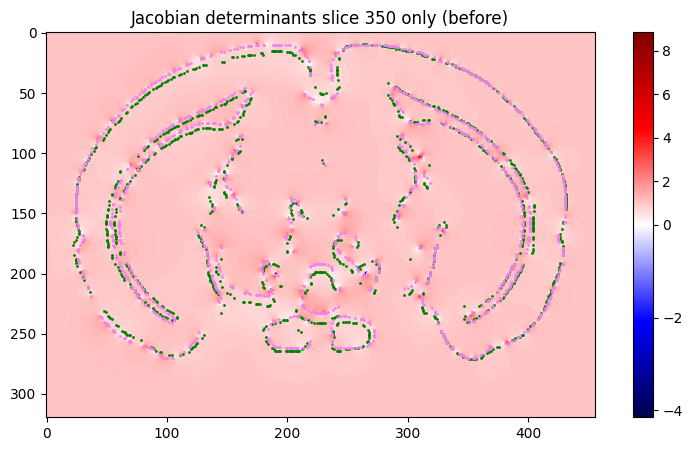

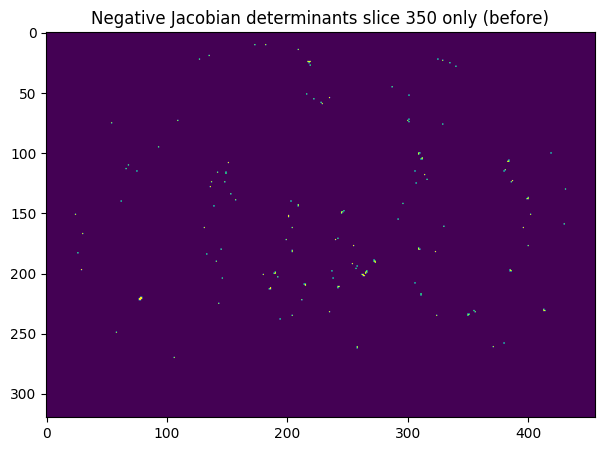

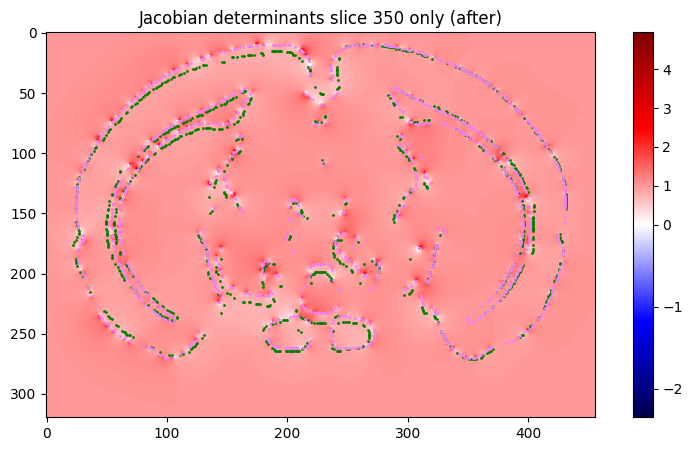

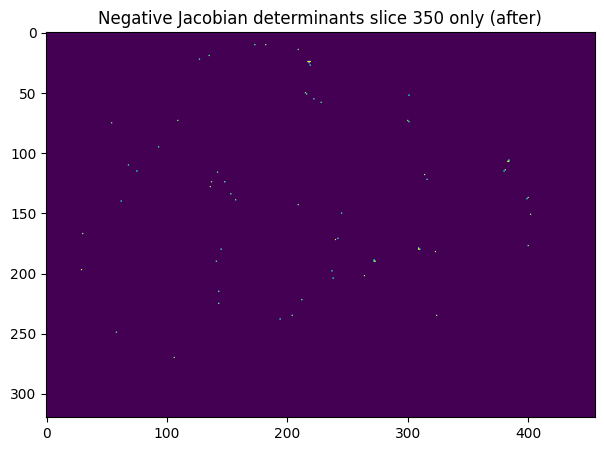

In [27]:
fixed_resolution = np.zeros((1, 320, 456))

# Compute the 3D Laplacian of the ORIGINAL points and retrieve the Jacobian determinant field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet = jacobian.sitk_jacobian_determinant(deformation)

# Compute the 3D Laplacian of the NEW CORRECTED points and retrieve the Jacobian determinant field
deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints_corrected, fpoints_corrected)
jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)

# Print the number of negative or zero Jacobian determinants
print("\nBefore - number of negative or zero Jacobian determinants:", np.sum(jdet <= 0))
print("Before - minimum Jacobian determinant:", jdet.min())
print("Before - maximum Jacobian determinant:", jdet.max())
print()

print("After - number of negative or zero Jacobian determinants:", np.sum(jdet_corrected <= 0))
print("After - minimum Jacobian determinant:", jdet_corrected.min())
print("After - maximum Jacobian determinant:", jdet_corrected.max())

# Plot the Jacobian determinant values of the original
norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (before)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (before)")
plt.show()

# Plot the Jacobian determinant values of the corrected
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_corrected.min(), -1), vcenter=0, vmax=jdet_corrected.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints_corrected[:, 2], mpoints_corrected[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (after)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (after)")
plt.show()


In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_displacement_vectors(deformation, section_idx, step=1, point=None, jacobian_det=None, offset=20):
    """
    Plot the displacement vectors in a deformation field.
    
    Parameters:
    - deformation: The deformation field (3D vector field).
    - section_idx: The index of the section to plot (z-coordinate).
    - step: The step size for sampling points (default is 10).
    """
    # Extract the deformation vectors for the specified section
    deformation_section = deformation[:, section_idx, :, :]
    
    # Create a grid of points
    y, x = np.mgrid[0:deformation_section.shape[1]:step, 0:deformation_section.shape[2]:step]
    
    # Extract the displacement vectors
    u = deformation_section[1, y, x]  # Displacement in y-direction
    v = deformation_section[2, y, x]  # Displacement in x-direction
    
    # Plot the displacement vectors using quiver
    plt.figure(figsize=(10, 10))
    if jacobian_det is not None:
        plt.imshow(jacobian_det[section_idx] < 0, cmap='viridis', alpha=0.5)
    plt.imshow(np.zeros_like(deformation_section[0]), cmap='gray', alpha=0.5)  # Background image
    plt.quiver(x, y, v, u, color='red', angles='xy', scale_units='xy', scale=0.75)
    plt.title(f"Displacement Vectors in Deformation Field (Section {section_idx})")
    plt.xlabel('X')
    plt.ylabel('Y')
    if point is not None:
        plt.scatter(point[1], point[0], color='green', s=10)
        plt.xlim(point[1] - offset, point[1] + offset)
        plt.ylim(point[0] - offset, point[0] + offset)
    
    plt.show()

# Example usage
section_idx = 350  # Replace with actual section index

plot_displacement_vectors(corrected_deformation, section_idx, point=(179, 309), jacobian_det=corrected_jacobian_det_sitk)

NameError: name 'corrected_deformation' is not defined